In [1]:
import pickle
import numpy as np
import collections
import matplotlib.pyplot as plt
import copy
import matplotlib.ticker as ticker
import mpmath as mp
from mpmath import gammainc

In [2]:
def power_law(x,s_min, s_max, alpha):
    C = ((1-alpha)/(s_max**(1-alpha)-s_min**(1-alpha)))
    return [C*x[i]**(-alpha) for i in range(len(x))]

def stretched_exponential(x,s_min,lamda,beta):
    C = beta*np.exp((s_min**beta)/lamda)/lamda
    return [C*(x[i]**(beta-1))*np.exp(-(x[i]**beta)/lamda) for i in range(len(x))]

def exponential(x,s_min,lamda):
    C = lamda*np.exp(lamda*s_min)
    return [C*np.exp(-lamda*x[i]) for i in range(len(x))]

def truncated_power_law(x,s_min,alpha,lamda):
    C = float(((lamda)**(1-alpha))/gammainc(1-alpha, s_min*lamda))
    return [C*(x[i]**(-alpha))*(np.exp(-lamda*x[i])) for i in range(len(x))]

In [3]:
grid_sizes = [128,256,512,1024]
density = 0.59
replicates = [1,2,3,4,5]
numbers_per_replicate = 2000000
dpt = []
npt = []
dictionary = {}
for grid_size in grid_sizes:
    del dpt
    del npt
    dpt = []
    npt = []
    for replicate in replicates:
        filename_dp = "dp_transformations_" + str(grid_size) + "_" + str(density) + "_" + str(numbers_per_replicate) + "_" + str(replicate) + ".txt"
        filename_np = "np_transformations_" + str(grid_size) + "_" + str(density) + "_" + str(numbers_per_replicate) + "_" + str(replicate) + ".txt"
        with open(filename_dp) as f:
            dpt.extend([tuple(map(int, i.split(' '))) for i in f])
        with open(filename_np) as f:
            npt.extend([tuple(map(int, i.split(' '))) for i in f])

    npscs = [abs(i[1]-i[0]) for i in npt]
    npsc_freqs = dict(collections.Counter(npscs))
    npsc_freqs = {k: v / (len(npscs)) for k, v in npsc_freqs.items()}

    dpscs = [abs(i[1]-i[0]) for i in dpt]
    dpsc_freqs = dict(collections.Counter(dpscs))
    dpsc_freqs = {k: v / (len(dpscs)) for k, v in dpsc_freqs.items()}

    np_lists = sorted(npsc_freqs.items()) 
    dp_lists = sorted(dpsc_freqs.items()) 

    np_x, np_y = zip(*np_lists)
    dp_x, dp_y = zip(*dp_lists)
    
    cy_dp = []
    cy_np = []
    for i in range(len(dp_y)):
        cy_dp.append(sum([dp_y[j] for j in range(i,len(dp_y))]))
    for i in range(len(np_y)):
        cy_np.append(sum([np_y[j] for j in range(i,len(np_y))]))
    
    dictionary[str(grid_size)+'_np_x'] = np_x
    dictionary[str(grid_size)+'_dp_x'] = dp_x
    dictionary[str(grid_size)+'_np_y'] = np_y
    dictionary[str(grid_size)+'_dp_y'] = dp_y
    dictionary[str(grid_size)+'_cy_dp'] = cy_dp
    dictionary[str(grid_size)+'_cy_np'] = cy_np

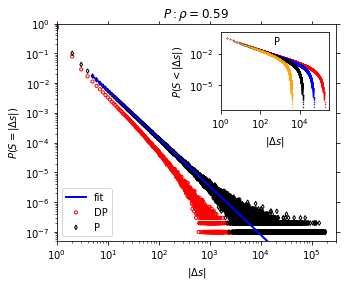

In [4]:
# Determined using the Fitting Notebook 
x_max = max(np_x)
x_min = 5
alpha = 1.608
lamda = 1/224091.1

x = [i for i in range(x_min,x_max+1)]
y = truncated_power_law(x, x_min, alpha, lamda)
A = (np_y[4]/y[0])
y = [(np_y[4]/y[0])*i for i in y]


fig, ax1 = plt.subplots(figsize=(5,4))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.58, 0.58, 0.3, 0.27]
ax2 = fig.add_axes([left, bottom, width, height])



ax1.scatter(dictionary['1024_dp_x'], dictionary['1024_dp_y'],s=10,marker='o',label='DP',color='red',facecolors='none')
ax1.scatter(dictionary['1024_np_x'], dictionary['1024_np_y'],s=10,marker='d',label='P',color='black',facecolors='none')
ax1.plot(x,y,color="blue",linewidth=2,label='fit')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$|\Delta s|$')
ax1.set_ylabel('$P(S=|\Delta s|)$')
ax1.legend(loc="lower left")
ax1.set_ylim(5*10**(-8),10**(0))
ax1.set_xlim(1,300000)
ax1.tick_params(bottom=True,top=True,left=True,right=True)


ax2.scatter(dictionary['1024_np_x'], dictionary['1024_cy_np'],marker='.',s=0.8,color='red',label='1024')
ax2.scatter(dictionary['512_np_x'], dictionary['512_cy_np'],marker='.',s=0.8,color='blue',label='512')
ax2.scatter(dictionary['256_np_x'], dictionary['256_cy_np'],marker='.',s=0.8,color='black',label='256')
ax2.scatter(dictionary['128_np_x'], dictionary['128_cy_np'],marker='.',s=0.8,color='orange',label='128')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('$|\Delta s|$')
ax2.set_ylabel('$P(S<|\Delta s|)$')
#ax2.legend(loc="lower left")
ax2.set_ylim(5*10**(-8),10**(0))
ax2.set_xlim(1,300000)
ax2.text(0.55, 0.85, 'P', transform=ax2.transAxes, ha="right")
ax1.set_title('$P: \\rho = $'+str(density))

#plt.savefig("Figure_5.png",dpi=300)

del dictionary 